In [1]:
!pip install ydf koolbox scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import optuna
import keras
import json
import glob
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

2025-05-01 11:15:53.608506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746098153.828396      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746098153.896410      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"

    metric = root_mean_squared_error
    target = "Calories"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

In [5]:
mutual_info = mutual_info_regression(X, y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.640567
Body_Temp,1.120766
Heart_Rate,0.976966
Age,0.098387
Height,0.056501
Weight,0.055709
Sex,0.017174


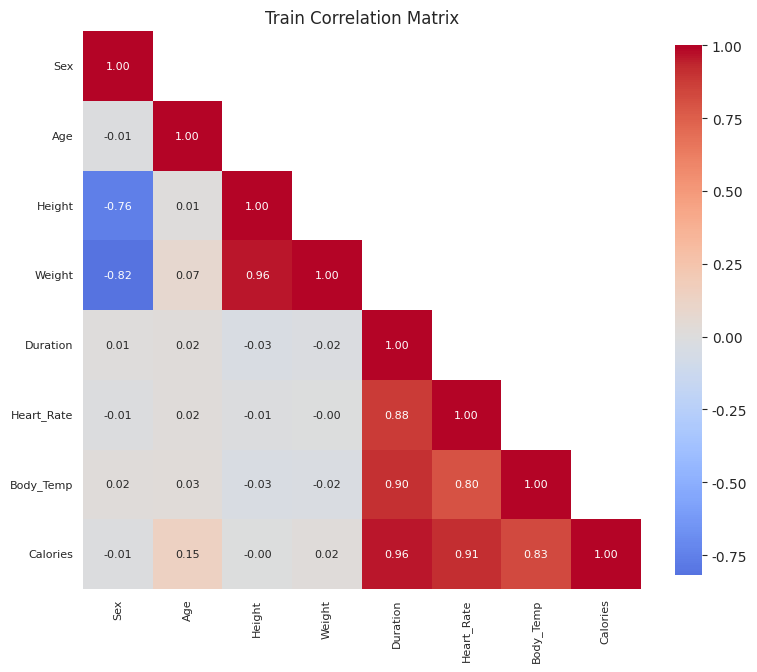

In [6]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(8, 8))

corr_train = train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax
)

ax.set_title('Train Correlation Matrix')
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

# Training base models

In [7]:
histgb_params = {
    "l2_regularization": 83.89023753261954,
    "learning_rate": 0.014076263018504506,
    "max_depth": 167,
    "max_features": 0.35671906170746404,
    "max_iter": 2175,
    "max_leaf_nodes": 441,
    "min_samples_leaf": 41,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5099047573235393,
    "learning_rate": 0.04655222942419148,
    "min_child_samples": 39,
    "min_child_weight": 0.5763597850247795,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 94,
    "random_state": 42,
    "reg_alpha": 13.37124947203867,
    "reg_lambda": 3.4607082189282656,
    "subsample": 0.8594971769419172,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.44242724444333914,
    "learning_rate": 0.02648790357768195,
    "min_child_samples": 31,
    "min_child_weight": 0.565923097348698,
    "n_estimators": 10000,
    "n_jobs": -1,
    "num_leaves": 91,
    "random_state": 42,
    "reg_alpha": 14.802741846604295,
    "reg_lambda": 3.285199583781151,
    "subsample": 0.4765616561570595,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.562776356802306,
    "colsample_bynode": 0.9612908685331664,
    "colsample_bytree": 0.6576899092549643,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 6.906307575453604,
    "learning_rate": 0.035818175355750034,
    "max_depth": 79,
    "max_leaves": 94,
    "min_child_weight": 54,
    "n_estimators": 10000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 40.48896149819585,
    "reg_lambda": 50.48291846164928,
    "subsample": 0.987369044259711,
    "verbosity": 0
}

cb_params = {
    "border_count": 197,
    "colsample_bylevel": 0.5512194940746528,
    "depth": 10,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 0.8315140039900148,
    "learning_rate": 0.04835894985543038,
    "min_child_samples": 248,
    "random_state": 42,
    "random_strength": 0.269215705791639,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8
}

In [8]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [9]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_error: 0.0597 - Time: 77.87 s
--- Fold 1 - root_mean_squared_error: 0.0606 - Time: 77.05 s
--- Fold 2 - root_mean_squared_error: 0.0599 - Time: 78.67 s
--- Fold 3 - root_mean_squared_error: 0.0603 - Time: 66.39 s
--- Fold 4 - root_mean_squared_error: 0.0595 - Time: 76.00 s

------ Overall root_mean_squared_error: 0.0600 - Mean root_mean_squared_error: 0.0600 ± 0.0004 - Time: 377.48 s


## LightGBM (gbdt)

In [10]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0602928	valid_0's l2: 0.00363522
[2000]	valid_0's rmse: 0.0602702	valid_0's l2: 0.00363249
Early stopping, best iteration is:
[1964]	valid_0's rmse: 0.0602702	valid_0's l2: 0.00363249
--- Fold 0 - root_mean_squared_error: 0.0603 - Time: 41.84 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.061355	valid_0's l2: 0.00376443
Early stopping, best iteration is:
[1514]	valid_0's rmse: 0.0613089	valid_0's l2: 0.00375879
--- Fold 1 - root_mean_squared_error: 0.0613 - Time: 41.33 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0606679	valid_0's l2: 0.00368059
Early stopping, best iteration is:
[1409]	valid_0's rmse: 0.0606353	valid_0's l2: 0.00367664
--- Fold 2 - root_mean_squared_error: 0.0606 - Time: 39.38 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0608723

## LightGBM (goss)

In [11]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0612992	valid_0's l2: 0.00375759
[2000]	valid_0's rmse: 0.0605151	valid_0's l2: 0.00366207
[3000]	valid_0's rmse: 0.0602939	valid_0's l2: 0.00363536
[4000]	valid_0's rmse: 0.0601906	valid_0's l2: 0.0036229
[5000]	valid_0's rmse: 0.0601194	valid_0's l2: 0.00361434
[6000]	valid_0's rmse: 0.0600721	valid_0's l2: 0.00360866
[7000]	valid_0's rmse: 0.0600373	valid_0's l2: 0.00360448
[8000]	valid_0's rmse: 0.0600074	valid_0's l2: 0.00360089
[9000]	valid_0's rmse: 0.0599836	valid_0's l2: 0.00359804
[10000]	valid_0's rmse: 0.0599618	valid_0's l2: 0.00359542
Did not meet early stopping. Best iteration is:
[10000]	valid_0's rmse: 0.0599618	valid_0's l2: 0.00359542
--- Fold 0 - root_mean_squared_error: 0.0600 - Time: 399.71 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.062448	valid_0's l2: 0.00389975
[2000]	valid_0's rmse: 0.0615246	valid_0's l2

## XGBoost

In [12]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000
}

xgb_trainer.fit(X, y, fit_args)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:0.93050
[1000]	validation_0-rmse:0.08428
[1308]	validation_0-rmse:0.08410
--- Fold 0 - root_mean_squared_error: 0.0841 - Time: 31.99 s

[0]	validation_0-rmse:0.93287
[1000]	validation_0-rmse:0.09084
[1992]	validation_0-rmse:0.08782
--- Fold 1 - root_mean_squared_error: 0.0878 - Time: 47.49 s

[0]	validation_0-rmse:0.93158
[1000]	validation_0-rmse:0.08906
[1893]	validation_0-rmse:0.08693
--- Fold 2 - root_mean_squared_error: 0.0869 - Time: 42.52 s

[0]	validation_0-rmse:0.93005
[1000]	validation_0-rmse:0.08709
[1554]	validation_0-rmse:0.08561
--- Fold 3 - root_mean_squared_error: 0.0856 - Time: 35.81 s

[0]	validation_0-rmse:0.93080
[1000]	validation_0-rmse:0.08570
[1859]	validation_0-rmse:0.08402
--- Fold 4 - root_mean_squared_error: 0.0840 - Time: 43.85 s


------ Overall root_mean_squared_error: 0.0857 - Mean root_mean_squared_error: 0.0857 ± 0.0015 - Time: 203.28 s


## CatBoost

In [13]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X, y, fit_args)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostRegressor

0:	learn: 0.9185429	test: 0.9177248	best: 0.9177248 (0)	total: 131ms	remaining: 10m 52s
1000:	learn: 0.0548001	test: 0.0591492	best: 0.0591480 (976)	total: 52.7s	remaining: 3m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05913662081
bestIteration = 1123

Shrink model to first 1124 iterations.
--- Fold 0 - root_mean_squared_error: 0.0591 - Time: 65.29 s

0:	learn: 0.9179589	test: 0.9201490	best: 0.9201490 (0)	total: 72.8ms	remaining: 6m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05976392646
bestIteration = 718

Shrink model to first 719 iterations.
--- Fold 1 - root_mean_squared_error: 0.0598 - Time: 42.99 s

0:	learn: 0.9182888	test: 0.9187499	best: 0.9187499 (0)	total: 86.9ms	remaining: 7m 14s
1000:	learn: 0.0547763	test: 0.0591204	best: 0.0591190 (994)	total: 52.6s	remaining: 3m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05910178961
bestIteration = 1196

Shrink model to 

## Yggdrasil

In [14]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [15]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ydf_trainer.fit(X, y)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_error: 0.0606 - Time: 82.39 s
--- Fold 1 - root_mean_squared_error: 0.0611 - Time: 83.57 s
--- Fold 2 - root_mean_squared_error: 0.0604 - Time: 74.15 s
--- Fold 3 - root_mean_squared_error: 0.0613 - Time: 68.55 s
--- Fold 4 - root_mean_squared_error: 0.0605 - Time: 95.55 s

------ Overall root_mean_squared_error: 0.0608 - Mean root_mean_squared_error: 0.0608 ± 0.0004 - Time: 405.79 s


## Neural networks

In [16]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

In [17]:
pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ['Sex']),
            
        ],
        remainder=StandardScaler()
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)

In [18]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [19]:
def scheduler(epoch, lr):    
    if epoch % 3 == 0 and epoch:
        return lr / 2
    return lr

nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.01),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=50, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

2025-05-01 12:30:06.047426: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
nn_bag = BaggingRegressor(
    nn_model,
    n_estimators=5,
    random_state=CFG.seed,
)

In [21]:
nn_trainer = Trainer(
    nn_bag,
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=root_mean_squared_error,
    task="regression"
)

nn_trainer.fit(X, y)

scores["KerasANN"] = nn_trainer.fold_scores
oof_preds["KerasANN"] = nn_trainer.oof_preds
test_preds["KerasANN"] = nn_trainer.predict(X_test)

Training BaggingRegressor



2025-05-01 12:30:06.567441: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 12:31:58.140475: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 0 - root_mean_squared_error: 0.0617 - Time: 550.28 s


2025-05-01 12:39:21.403332: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 12:41:05.191384: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 1 - root_mean_squared_error: 0.0632 - Time: 545.54 s


2025-05-01 12:48:27.310951: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 12:50:10.571268: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 2 - root_mean_squared_error: 0.0620 - Time: 536.45 s


2025-05-01 12:57:24.244106: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 12:59:04.011787: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 3 - root_mean_squared_error: 0.0620 - Time: 530.06 s


2025-05-01 13:06:15.131650: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-01 13:08:00.068865: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 4 - root_mean_squared_error: 0.0616 - Time: 548.20 s

------ Overall root_mean_squared_error: 0.0621 - Mean root_mean_squared_error: 0.0621 ± 0.0006 - Time: 2713.59 s


2025-05-01 13:15:20.961234: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 13:15:26.026781: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

# Ensembling with Ridge

In [22]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [23]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [24]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-01 13:15:44,791] A new study created in memory with name: no-name-bcbcb060-cb71-4932-b77c-18a92ed22c53
[I 2025-05-01 13:15:59,288] Trial 2 finished with value: 0.05918298842075524 and parameters: {'alpha': 7.443693911128796, 'tol': 0.00021862824622211925}. Best is trial 2 with value: 0.05918298842075524.
[I 2025-05-01 13:16:00,059] Trial 3 finished with value: 0.05918173210339185 and parameters: {'alpha': 0.5163325181237877, 'tol': 0.0026669512718341917}. Best is trial 3 with value: 0.05918173210339185.
[I 2025-05-01 13:16:00,092] Trial 1 finished with value: 0.05918198339831491 and parameters: {'alpha': 5.040524602846354, 'tol': 0.0011045408663317485}. Best is trial 3 with value: 0.05918173210339185.
[I 2025-05-01 13:16:00,099] Trial 0 finished with value: 0.059183999621653154 and parameters: {'alpha': 9.185900981325869, 'tol': 0.0006574968618824316}. Best is trial 3 with value: 0.05918173210339185.
[I 2025-05-01 13:16:14,525] Trial 6 finished with value: 0.0591820363581635

In [25]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 2.257746671141554,
  "tol": 0.008678597385677795
}


In [26]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True),
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = np.expm1(ridge_trainer.predict(X_test))

Training Ridge

--- Fold 0 - root_mean_squared_error: 0.0590 - Time: 0.10 s
--- Fold 1 - root_mean_squared_error: 0.0597 - Time: 0.11 s
--- Fold 2 - root_mean_squared_error: 0.0590 - Time: 0.11 s
--- Fold 3 - root_mean_squared_error: 0.0593 - Time: 0.10 s
--- Fold 4 - root_mean_squared_error: 0.0588 - Time: 0.10 s

------ Overall root_mean_squared_error: 0.0592 - Mean root_mean_squared_error: 0.0592 ± 0.0003 - Time: 4.43 s


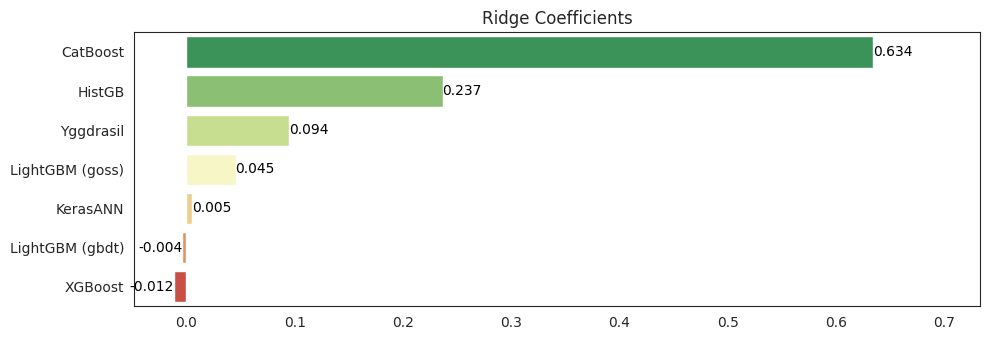

In [27]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [28]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.267525
1,750001,107.921522
2,750002,87.269868
3,750003,125.645349
4,750004,76.154871


# Results

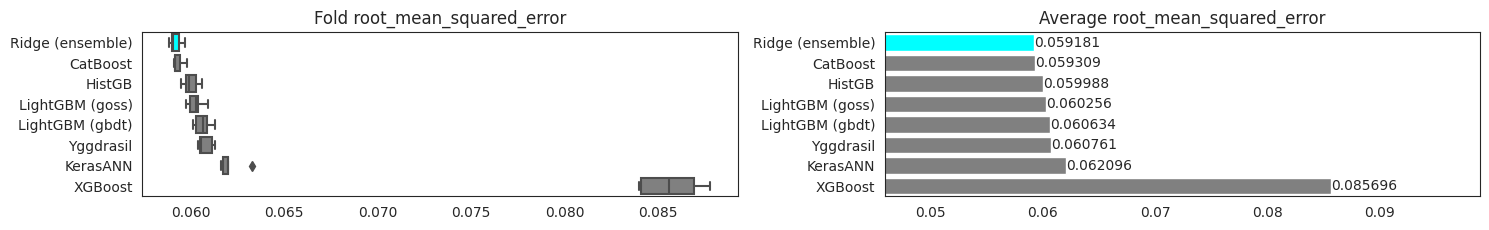

In [29]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [30]:
shutil.rmtree("catboost_info", ignore_errors=True)